In [89]:
from typing import Optional
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as tkr
from src.train.plots import Line
from src.processes.observables import Observable
import warnings
import h5py

In [90]:
def compute_hist_data(bins: np.ndarray, data: np.ndarray, bayesian=False, weights=None):
    if bayesian:
        hists = np.stack(
            [np.histogram(d, bins=bins, density=False, weights=weights)[0] for d in data], axis=0
        )
        y = hists[0]
        y_err = np.std(hists, axis=0)
    else:
        y, _ = np.histogram(data, bins=bins, density=False, weights=weights)
        y_err = np.sqrt(y)
    return y, y_err

# Irvine samples
feature_list = ["jet_mass", "jet_width", "jet_constituents", "soft_drop_jet_mass", "z_g", "tau_21"]
irvine_paths = [f"data/Irvine/omnifold_bigger_quantile_test/{f}.h5" for f in feature_list]

## Setup

In [91]:
plt.rc("font", family="serif", size=16)
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

COLORS = [f"C{i}" for i in range(10)]
COLORS_exp = ["#b30000", "#7c1158", "#4421af", "#1a53ff", "#0d88e6", "#00b7c7", "#5ad45a", "#8be04e", "#ebdc78"]

RECO_COLOR = COLORS[0]
HARD_COLOR = COLORS[1]
HERWIG_RECO_COLOR = COLORS_exp[0]
HERWIG_HARD_COLOR = COLORS_exp[1]
AFF_INN_COLOR = COLORS[2]
INN_COLOR = "firebrick"
CFM_COLOR = COLORS_exp[3]
P_DIDI_COLOR = "forestgreen"
UP_DIDI_COLOR = "darkorchid"
SB_COLOR = COLORS[2]
OMNI_COLOR = COLORS[8]

mpl.rcParams['font.size'] = 29 # 17 for SB on second panel
                               # larger for migration like 22
mpl.rcParams['lines.linewidth'] = 1.5
handlelength = .75 # handlelength in legend
handlewidth = 1.2 # handlelength in legend
observables_rect = (0.09,0.08,0.99,0.99) # to fix the axes box size in observbales plots

def hist_plot(
    pdf: PdfPages,
    lines: list[Line],
    bins: np.ndarray,
    observable: Observable,
    show_ratios: bool = True,
    title: Optional[str] = None,
    no_scale: bool = False,
    yscale: Optional[str] = None,
    show: bool = False,
    rect = None,
    ylabel = "Normalized",
    xlim = None,
    ylim = None,
    legend_kwargs = {},
    legend_callback = None,
    plot_third_on_second_panel = False,
    debug: bool = False,
):
    """
    Makes a single histogram plot, used for the observable histograms and clustering
    histograms.
    Args:
        pdf: Multipage PDF object
        lines: List of line objects describing the histograms
        bins: Numpy array with the bin boundaries
        show_ratios: If True, show a panel with ratios
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        n_panels = 1 + int(show_ratios) + int(plot_third_on_second_panel)
        fig, axs = plt.subplots(
            n_panels,
            1,
            sharex=True,
            figsize=(8.5, 7),
            gridspec_kw={"height_ratios": (3, 1, 1)[:n_panels], "hspace": 0.00},
        )
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
        if n_panels == 1:
            axs = [axs]

        for k_line, line in enumerate(lines):
            if line.vline:
                axs[0].axvline(line.y, label=line.label, color=line.color, linestyle=line.linestyle)
                continue
            integral = np.sum((bins[1:] - bins[:-1]) * line.y)
            scale = 1 / integral if integral != 0.0 else 1.0
            if line.y_ref is not None:
                ref_integral = np.sum((bins[1:] - bins[:-1]) * line.y_ref)
                ref_scale = 1 / ref_integral if ref_integral != 0.0 else 1.0
            if no_scale:
                scale = 1.
                ref_scale = 1.
            
            if debug: print("Actual values plotted:", line.y * scale)
            hist_line(
                axs[0],
                bins,
                line.y * scale,
                line.y_err * scale if line.y_err is not None else None,
                label=line.label,
                color=line.color,
                fill=line.fill,
                linestyle=line.linestyle
            )

            if line.y_ref is not None:
                ratio = (line.y * scale) / (line.y_ref * ref_scale)
                ratio_isnan = np.isnan(ratio) | np.isinf(ratio)
                if line.y_err is not None:
                    if len(line.y_err.shape) == 2:
                        ratio_err = (line.y_err * scale) / (line.y_ref * ref_scale)
                        ratio_err[:, ratio_isnan] = 0.0
                    else:
                        ratio_err = np.sqrt((line.y_err / line.y) ** 2)
                        ratio_err[ratio_isnan] = 0.0
                else:
                    ratio_err = None
                ratio[ratio_isnan] = 1.0
                if not plot_third_on_second_panel:
                    hist_line(
                        axs[1], bins, ratio, ratio_err, label=None, color=line.color
                    )
                elif plot_third_on_second_panel and k_line < 4:
                    hist_line(
                        axs[1], bins, ratio, ratio_err, label=None, color=line.color
                    )
                else:
                    hist_line(
                        axs[2], bins, ratio, ratio_err, label=None, color=line.color
                    )
        if legend_callback is not None:
            legend_callback(axs)

        #if "Jet mass" in observable.tex_label:
        #    axs[0].legend(frameon=False, **legend_kwargs)
        axs[0].legend(frameon=False, **legend_kwargs)    

        axs[0].set_ylabel(ylabel)
        axs[0].set_yscale(observable.yscale if yscale is None else yscale)
        if ylim is not None:
            axs[0].set_ylim(*ylim)
        #if title is not None:
        #    self.corner_text(axs[0], title, "left", "top")
            
        if show_ratios:
            axs[1].set_ylabel(r"$\frac{\mathrm{Model}}{\mathrm{Truth}}$")
            axs[1].set_yticks([0.95, 1, 1.05])
            axs[1].set_ylim([0.9, 1.1])
            axs[1].axhline(y=1, c="black", ls="--", lw=0.7)
            axs[1].axhline(y=1.05, c="black", ls="dotted", lw=0.5)
            axs[1].axhline(y=0.95, c="black", ls="dotted", lw=0.5)
            if plot_third_on_second_panel:
                axs[2].set_ylabel(r"$\frac{\mathrm{Model}}{\mathrm{Truth}}$")
                axs[2].set_yticks([0.95, 1, 1.05])
                axs[2].set_ylim([0.9, 1.1])
                axs[2].axhline(y=1, c="black", ls="--", lw=0.7)
                axs[2].axhline(y=1.05, c="black", ls="dotted", lw=0.5)
                axs[2].axhline(y=0.95, c="black", ls="dotted", lw=0.5)
        
        unit = "" if observable.unit is None else f" [{observable.unit}]"
        axs[-1].set_xlabel(f"${{{observable.tex_label}}}${unit}")
        axs[-1].set_xscale(observable.xscale)
        if xlim is None:
            axs[-1].set_xlim(bins[0], bins[-1])
        else:
            axs[-1].set_xlim(*xlim)

        plt.savefig(pdf, format="pdf")
        plt.close()

def hist_line(
    ax: mpl.axes.Axes,
    bins: np.ndarray,
    y: np.ndarray,
    y_err: np.ndarray,
    label: str,
    color: str,
    linestyle: str = "solid",
    fill: bool = False,
):
    """
    Plot a stepped line for a histogram, optionally with error bars.
    Args:
        ax: Matplotlib Axes
        bins: Numpy array with bin boundaries
        y: Y values for the bins
        y_err: Y errors for the bins
        label: Label of the line
        color: Color of the line
        linestyle: line style
        fill: Filled histogram
    """

    dup_last = lambda a: np.append(a, a[-1])

    if fill:
        ax.fill_between(
            bins, dup_last(y), label=label, facecolor=color, step="post", alpha=0.2
        )
    else:
        ax.step(
            bins,
            dup_last(y),
            label=label,
            color=color,
            linewidth=1.5,
            where="post",
            ls=linestyle,
        )
    if y_err is not None:
        if len(y_err.shape) == 2:
            y_low = y_err[0]
            y_high = y_err[1]
        else:
            y_low = y - y_err
            y_high = y + y_err

        ax.step(
            bins,
            dup_last(y_high),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.step(
            bins,
            dup_last(y_low),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.fill_between(
            bins,
            dup_last(y_low),
            dup_last(y_high),
            facecolor=color,
            alpha=0.3,
            step="post",
        )


## Pythia Small (BAYESIAN MODELS)

In [8]:
'''
route_CFM = "output/CFM/20240221_104130_small-long-bay"
route_P_DIDI = "output/DiDi/paired/20240221_104350_small-long-bay"
route_UP_DIDI = "output/DiDi/unpaired/20240221_104446_small-long-bay"
route_INN = "output/INN/RQS/20240221_104809_small-long-bay"
'''

route_CFM = "output/CFM/20240305_112202_50k"
route_P_DIDI = "output/DiDi/paired/20240305_112202_50k"
route_UP_DIDI = "output/DiDi/unpaired/20240305_112448_50k"
route_INN = "output/INN/RQS/20240305_112221_50k"

routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/new_dataset/"

30 UNFOLDINGS


In [10]:
comparison_P_DIDI = comparison_all[1]
comparison_UP_DIDI = comparison_all[2]

with PdfPages(final_route + "SB_DiDi/observables-SB_DiDi-bay-50k.pdf") as pp:
    for observable_P_DIDI, observable_UP_DIDI in zip(comparison_P_DIDI, comparison_UP_DIDI):

        
        # Reco
        line_reco = observable_P_DIDI["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_P_DIDI["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDi paired
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "DiDi-P"
        
        # DiDi unpaired
        obs_UP_DIDI = observable_UP_DIDI["obs"]
        bins_UP_DIDI = observable_UP_DIDI["bins"]
        line_UP_DIDI = observable_UP_DIDI["lines"][3]
        line_UP_DIDI.color = UP_DIDI_COLOR
        line_UP_DIDI.label = "DiDi-U"
        
        # SB
        #line_SB = observable_P_DIDI["lines"][4]
        #line_SB.color = "black"
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_P_DIDI, line_UP_DIDI],#, line_SB],
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_P_DIDI.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_P_DIDI.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_P_DIDI.tex_label else [-0.1, 3.2] if "subjettiness" in obs_P_DIDI.tex_label else None,
            plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label or "subjettiness" in obs_P_DIDI.tex_label else "upper right" if "momentum" in obs_P_DIDI.tex_label else "best"), 'handlelength' : handlelength},
        )

DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U


In [11]:
comparison_CFM = comparison_all[0]
comparison_INN = comparison_all[3]

with PdfPages(final_route + "CFM_INN/observables-CFM_INN-bay-50k-presen.pdf") as pp:
    for observable_CFM, observable_INN in zip(comparison_CFM, comparison_INN):

        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = CFM_COLOR
        line_CFM.label = "CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "cINN"
        
        ylim = [.9, 1e1] if "momentum" in obs_INN.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN],#, line_SB],
            bins=bins_INN,
            observable=obs_INN,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_INN.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_INN.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_INN.tex_label else [-0.1, 3.2] if "subjettiness" in obs_INN.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label or "subjettiness" in obs_INN.tex_label else "upper right" if "momentum" in obs_INN.tex_label else "best"), 'handlelength' : handlelength},
        )

CFM
cINN
CFM
cINN
CFM
cINN
CFM
cINN
CFM
cINN
CFM
cINN


## Pythia Large (BAYESIAN MODELS)

In [92]:
'''
route_CFM = "output/CFM/20240226_095540_large-long-bay"
route_P_DIDI = "output/DiDi/paired/20240226_095540_large-long-bay"
route_UP_DIDI = "output/DiDi/unpaired/20240226_095934_large-long-bay"
route_INN = "output/INN/RQS/20240226_111234_large-long-bay"
'''

# 35h training

route_CFM = "output/CFM/20240229_175518_large-maxruntime"
route_P_DIDI = "output/DiDi/paired/20240229_175449_large-maxruntime"
route_UP_DIDI = "output/DiDi/unpaired/20240229_175919_large-maxruntime"
route_INN = "output/INN/RQS/20240229_175520_large-maxruntime"


routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/new_dataset/"

30 UNFOLDINGS


In [6]:
comparison_P_DIDI = comparison_all[1]
comparison_UP_DIDI = comparison_all[2]

with PdfPages(final_route + "SB_DiDi/LARGE_maxruntime-observables-SB_DiDi-bay.pdf") as pp:
    for observable_P_DIDI, observable_UP_DIDI in zip(comparison_P_DIDI, comparison_UP_DIDI):

        
        # Reco
        line_reco = observable_P_DIDI["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_P_DIDI["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDi paired
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "DiDi-P"
        
        # DiDi unpaired
        obs_UP_DIDI = observable_UP_DIDI["obs"]
        bins_UP_DIDI = observable_UP_DIDI["bins"]
        line_UP_DIDI = observable_UP_DIDI["lines"][3]
        line_UP_DIDI.color = UP_DIDI_COLOR
        line_UP_DIDI.label = "DiDi-U"
        
        # SB
        #line_SB = observable_P_DIDI["lines"][4]
        #line_SB.color = "black"
        ylim = [.9, 1e1] if "momentum" in obs_P_DIDI.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_P_DIDI, line_UP_DIDI],#, line_SB],
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_P_DIDI.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_P_DIDI.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_P_DIDI.tex_label else [-0.1, 3.2] if "subjettiness" in obs_P_DIDI.tex_label else None,
            plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label or "subjettiness" in obs_P_DIDI.tex_label else "upper right" if "momentum" in obs_P_DIDI.tex_label else "best"), 'handlelength' : handlelength},
        )

DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U
DiDi-P
DiDi-U


In [93]:
comparison_CFM = comparison_all[0]
comparison_INN = comparison_all[3]

with PdfPages(final_route + "CFM_INN_Irvine/LARGE-observables-bay.pdf") as pp:
    for k, (observable_CFM, observable_INN) in enumerate(zip(comparison_CFM, comparison_INN)):

        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = CFM_COLOR
        line_CFM.label = "CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "cINN"

        # Irvine
        with h5py.File(irvine_paths[k], "r") as f:
            data_gen = f["lvd"]
            y_VLD, y_VLD_err = compute_hist_data(bins_CFM, data_gen, bayesian=False)
        line_VLD = Line(
            y=y_VLD,
            y_err=y_VLD_err,
            y_ref = line_hard.y,
            color=COLORS_exp[5],
            linestyle="solid",
            label="LVD"
        )
        
        ylim = [.9, 1e1] if "momentum" in obs_INN.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN, line_VLD],#, line_SB],
            bins=bins_INN,
            observable=obs_INN,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_INN.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_INN.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_INN.tex_label else [-0.1, 3.2] if "subjettiness" in obs_INN.tex_label else None,
            plot_third_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_INN.tex_label or "multiplicity" in obs_INN.tex_label else "lower left" if "width" in obs_INN.tex_label else "upper left" if "Groomed mass" in obs_INN.tex_label or "subjettiness" in obs_INN.tex_label else "upper right" if "momentum" in obs_INN.tex_label else "best"), 'handlelength' : handlelength},
        )

## Small vs Large

In [28]:
'''
route_CFM = "output/CFM/20240226_095540_large-long-bay"
route_P_DIDI = "output/DiDi/paired/20240226_095540_large-long-bay"
route_UP_DIDI = "output/DiDi/unpaired/20240226_095934_large-long-bay"
route_INN = "output/INN/RQS/20240226_111234_large-long-bay"
'''

# Large

route_CFM = "output/CFM/20240229_175518_large-maxruntime"
route_P_DIDI = "output/DiDi/paired/20240229_175449_large-maxruntime"
route_UP_DIDI = "output/DiDi/unpaired/20240229_175919_large-maxruntime"
route_INN = "output/INN/RQS/20240229_175520_large-maxruntime"


routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_large = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        comparison_large.append(pickle.load(f))


# Small

route_CFM = "output/CFM/20240305_112202_50k"
route_P_DIDI = "output/DiDi/paired/20240305_112202_50k"
route_UP_DIDI = "output/DiDi/unpaired/20240305_112448_50k"
route_INN = "output/INN/RQS/20240305_112221_50k"

routes = [route_CFM, route_P_DIDI, route_UP_DIDI, route_INN]
comparison_small = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        comparison_small.append(pickle.load(f))

n_unfoldings = int(comparison_small[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/new_dataset/"

30 UNFOLDINGS


In [29]:
with PdfPages(final_route + "SB_DiDi/SB_DIDI-comparison-small_vs_large.pdf") as pp:
    for observable_DiDiP, observable_DiDiUP, observable_DiDiP_Large, observable_DiDiUP_Large in zip(comparison_small[1], comparison_small[2], comparison_large[1], comparison_large[2]):

        
        # Reco
        line_reco = observable_DiDiP["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_DiDiP["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # DiDiP
        obs_DiDiP = observable_DiDiP["obs"]
        bins_DiDiP = observable_DiDiP["bins"]
        line_DiDiP = observable_DiDiP["lines"][3]
        line_DiDiP.color = COLORS_exp[5]
        line_DiDiP.linestyle = "dashed"
        line_DiDiP.label = "DiDi-P"
        
        # DiDiUP
        obs_DiDiUP = observable_DiDiUP["obs"]
        bins_DiDiUP = observable_DiDiUP["bins"]
        line_DiDiUP = observable_DiDiUP["lines"][3]
        line_DiDiUP.color = COLORS_exp[6]
        line_DiDiUP.linestyle = "dashed"
        line_DiDiUP.label = "DiDi-U"

        # DiDiP large
        obs_DiDiP_large = observable_DiDiP_Large["obs"]
        bins_DiDiP_large = observable_DiDiP_Large["bins"]
        line_DiDiP_large = observable_DiDiP_Large["lines"][3]
        line_DiDiP_large.color = P_DIDI_COLOR
        line_DiDiP_large.label = "DiDi-P-l"
        
        # DiDiUP large
        obs_DiDiUP_large = observable_DiDiUP_Large["obs"]
        bins_DiDiUP_large = observable_DiDiUP_Large["bins"]
        line_DiDiUP_large = observable_DiDiUP_Large["lines"][3]
        line_DiDiUP_large.color = UP_DIDI_COLOR
        line_DiDiUP_large.label = "DiDi-U-l"
        
        # SB
        #line_SB = observable_DiDiP["lines"][4]
        #line_SB.color = "black"
        ylim = [.9, 1e1] if "momentum" in obs_DiDiP.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_DiDiP, line_DiDiUP, line_DiDiP_large, line_DiDiUP_large],#, line_SB],
            bins=bins_DiDiP,
            observable=obs_DiDiP,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_DiDiP.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_DiDiP.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_DiDiP.tex_label else [-0.1, 3.2] if "subjettiness" in obs_DiDiP.tex_label else None,
            plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_DiDiP.tex_label or "multiplicity" in obs_DiDiP.tex_label else "lower left" if "width" in obs_DiDiP.tex_label else "upper left" if "Groomed mass" in obs_DiDiP.tex_label or "subjettiness" in obs_DiDiP.tex_label else "upper right" if "momentum" in obs_DiDiP.tex_label else "best"), 'handlelength' : handlelength},
        )

DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo
DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo
DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo
DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo
DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo
DiDi-P
DiDi-U
henlo
DiDi-P-l
DiDi-U-l
henlo


In [23]:
with PdfPages(final_route + "CFM_INN/CFM_INN-comparison-small_vs_large.pdf") as pp:
    for observable_CFM, observable_INN, observable_CFM_Large, observable_INN_Large in zip(comparison_small[0], comparison_small[3], comparison_large[0], comparison_large[3]):

        
        # Reco
        line_reco = observable_CFM["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_CFM["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # CFM
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        line_CFM = observable_CFM["lines"][3]
        line_CFM.color = COLORS_exp[5]
        line_CFM.linestyle = "dashed"
        line_CFM.label = "CFM"
        
        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = COLORS_exp[6]
        line_INN.linestyle = "dashed"
        line_INN.label = "cINN"

        # CFM large
        obs_CFM_large = observable_CFM_Large["obs"]
        bins_CFM_large = observable_CFM_Large["bins"]
        line_CFM_large = observable_CFM_Large["lines"][3]
        line_CFM_large.color = CFM_COLOR
        line_CFM_large.label = "CFM-l"
        
        # INN large
        obs_INN_large = observable_INN_Large["obs"]
        bins_INN_large = observable_INN_Large["bins"]
        line_INN_large = observable_INN_Large["lines"][3]
        line_INN_large.color = INN_COLOR
        line_INN_large.label = "cINN-l"
        
        # SB
        #line_SB = observable_CFM["lines"][4]
        #line_SB.color = "black"
        ylim = [.9, 1e1] if "momentum" in obs_CFM.tex_label else None
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_CFM, line_INN, line_CFM_large, line_INN_large],#, line_SB],
            bins=bins_CFM,
            observable=obs_CFM,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs_CFM.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs_CFM.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_CFM.tex_label else [-0.1, 3.2] if "subjettiness" in obs_CFM.tex_label else None,
            plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_CFM.tex_label or "multiplicity" in obs_CFM.tex_label else "lower left" if "width" in obs_CFM.tex_label else "upper left" if "Groomed mass" in obs_CFM.tex_label or "subjettiness" in obs_CFM.tex_label else "upper right" if "momentum" in obs_CFM.tex_label else "best"), 'handlelength' : handlelength},
        )

CFM
cINN
henlo
CFM-l
cINN-l
henlo
CFM
cINN
henlo
CFM-l
cINN-l
henlo
CFM
cINN
henlo
CFM-l
cINN-l
henlo
CFM
cINN
henlo
CFM-l
cINN-l
henlo
CFM
cINN
henlo
CFM-l
cINN-l
henlo
CFM
cINN
henlo
CFM-l
cINN-l
henlo


## Migration2

### Small statistics

In [84]:
'''
route_gt = "output/CFM/20240221_104130_small-long-bay/gt_"
route_SB = ""
route_CFM = "output/CFM/20240221_104130_small-long-bay/"
route_P_DIDI = "output/DiDi/paired/20240221_104350_small-long-bay/"
route_UP_DIDI = "output/DiDi/unpaired/20240221_104446_small-long-bay/"
route_INN = "output/INN/RQS/20240221_104809_small-long-bay/"
'''

route_gt = "output/CFM/20240305_112202_50k/gt_"
route_SB = ""
route_CFM = "output/CFM/20240305_112202_50k/"
route_P_DIDI = "output/DiDi/paired/20240305_112202_50k/"
route_UP_DIDI = "output/DiDi/unpaired/20240305_112448_50k/"
route_INN = "output/INN/RQS/20240305_112221_50k/"

routes = [route_P_DIDI, route_UP_DIDI, route_CFM, route_INN, route_gt]#, route_SB]
migrations_all = []
for route in routes:
    with open(route + "migration2.pkl", "rb") as f:
        migrations_all.append(pickle.load(f))

final_route = "plots/new_dataset/migration/"

In [85]:
mpl.rcParams['font.size'] = 27.5 # 17 for SB on second panel
                               # larger for migration like 22
gt = False
reduce_titles = False
for i, prefix_fname, axis_label in zip(range(len(routes)), 
                                       ["DiDi_P", "DiDi_U", "CFM", "INN", "gt"],
                                       ["DiDi-P", "DiDi-U", "CFM", "cINN", "Hard"]):
    if i==4: gt = True
    #final_route = final_route + "title_only_on_gt/"
    with PdfPages(final_route + f"{prefix_fname}_migration2_50k.pdf") as pp:
        for k, obs in enumerate(migrations_all[i]):
            h = obs["h"]
            bins = obs["bins"]
            ranges = obs["ranges"]
            obs = obs["obs"]
            '''if k == 0:
                obs.tex_label = "m"
            elif k == 1:
                obs.tex_label = "\omega"
            elif k == 2:
                obs.tex_label = "N"
            elif k == 3:
                obs.tex_label = "\log{\\rho}"
            elif k == 4:
                obs.tex_label = "z_{g}"
            elif k == 5:
                obs.tex_label = "\\tau_{21}"'''

            cmap = plt.get_cmap('viridis')
            cmap.set_bad("white")
            fig, ax = plt.subplots(figsize=(6,5))

            unit = "" if obs.unit is None else f" [{obs.unit}]"
            fig.suptitle(f"${{{obs.tex_label}}}${unit}")
            fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.07, 0.08, 0.99, 0.99))

            
            im = ax.pcolormesh(bins, bins, h, cmap=cmap, rasterized=True, vmin=ranges[0], vmax=ranges[1])

            
            ax.set_xlim(bins[0], bins[-1])
            ax.set_ylim(bins[0], bins[-1])
            ax.set_xlabel("Reco")
            ax.set_ylabel(axis_label)
            fig.savefig(pp, format= "pdf")
            #fig.savefig(pp, format= "pdf", bbox_inches="tight")
            plt.close()

### Large statistics

In [86]:
route_gt = "output/CFM/20240229_175518_large-maxruntime/gt_"
route_SB = ""
route_CFM = "output/CFM/20240229_175518_large-maxruntime/"
route_P_DIDI = "output/DiDi/paired/20240229_175449_large-maxruntime/"
route_UP_DIDI = "output/DiDi/unpaired/20240229_175919_large-maxruntime/"
route_INN = "output/INN/RQS/20240229_175520_large-maxruntime/"

routes = [route_P_DIDI, route_UP_DIDI, route_CFM, route_INN, route_gt]#, route_SB]
migrations_all = []
for route in routes:
    with open(route + "migration2.pkl", "rb") as f:
        migrations_all.append(pickle.load(f))

final_route = "plots/new_dataset/migration/LARGEv2-"

In [87]:
mpl.rcParams['font.size'] = 27.5 # 17 for SB on second panel
                               # larger for migration like 22
gt = False
reduce_titles = False
for i, prefix_fname, axis_label in zip(range(len(routes)), 
                                       ["DiDi_P", "DiDi_U", "CFM", "INN", "gt"],
                                       ["DiDi-P", "DiDi-U", "CFM", "cINN", "Hard"]):
    if i==4: gt = True
    #final_route = final_route + "title_only_on_gt/"
    with PdfPages(final_route + f"{prefix_fname}_migration2.pdf") as pp:
        for k, obs in enumerate(migrations_all[i]):
            h = obs["h"]
            bins = obs["bins"]
            ranges = obs["ranges"]
            obs = obs["obs"]
            '''if k == 0:
                obs.tex_label = "m"
            elif k == 1:
                obs.tex_label = "\omega"
            elif k == 2:
                obs.tex_label = "N"
            elif k == 3:
                obs.tex_label = "\log{\\rho}"
            elif k == 4:
                obs.tex_label = "z_{g}"
            elif k == 5:
                obs.tex_label = "\\tau_{21}"'''

            cmap = plt.get_cmap('viridis')
            cmap.set_bad("white")
            fig, ax = plt.subplots(figsize=(6,5))

            unit = "" if obs.unit is None else f" [{obs.unit}]"
            fig.suptitle(f"${{{obs.tex_label}}}${unit}")
            fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.07, 0.08, 0.99, 0.99))

            
            im = ax.pcolormesh(bins, bins, h, cmap=cmap, rasterized=True, vmin=ranges[0], vmax=ranges[1])

            
            ax.set_xlim(bins[0], bins[-1])
            ax.set_ylim(bins[0], bins[-1])
            ax.set_xlabel("Reco")
            ax.set_ylabel(axis_label)
            fig.savefig(pp, format= "pdf")
            #fig.savefig(pp, format= "pdf", bbox_inches="tight")
            plt.close()

## Omnifold vs bOmnifold

### Reweighting Herwig onto Pythia

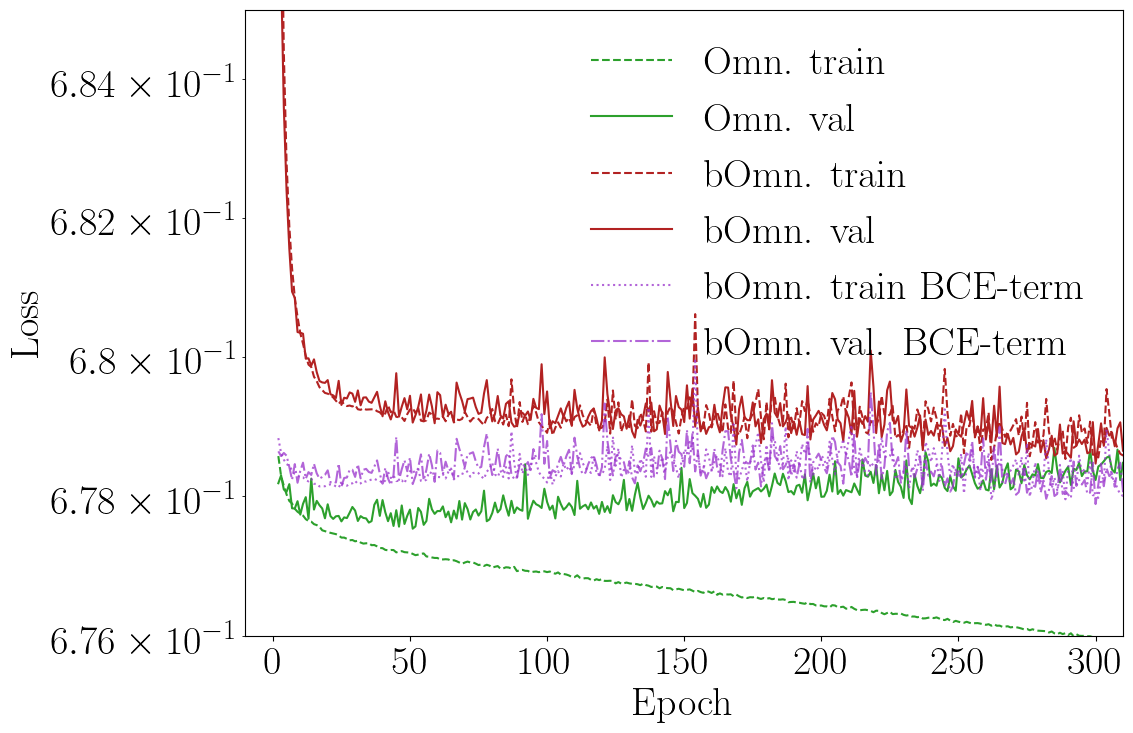

In [25]:
final_route = "plots/Omnifold/HtoP/"
'''
Losses
'''
#route_omnifold = "output/Omnifold/20240226_155542_olddatasets-HtoP-long/model"
#route_bOmnifold = "output/Omnifold/20240226_155816_olddatasets-HtoP-long-bay/model"

route_omnifold = "output/Omnifold/20240325_005402_olddatasets-HtoP-long-modeltrain/"
route_bOmnifold = "output/Omnifold/20240322_102708_olddatasets-HtoP-long-bay-modeltrain/"

# Load the dictionaries from the .pth files
losses_omnifold = torch.load(route_omnifold + "model/final.pth", map_location=torch.device('cpu'))['losses']
losses_bOmnifold = torch.load(route_bOmnifold + "model/final.pth", map_location=torch.device('cpu'))['losses']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = np.arange(1, len(losses_bOmnifold["tr_loss"][:]))
ax.plot(epochs + 1, losses_omnifold["tr_loss"][1:], linestyle= 'dashed', color = AFF_INN_COLOR, label = 'Omn. train')
ax.plot(epochs + 1, losses_omnifold["val_loss"][1:], linestyle= 'solid', color = AFF_INN_COLOR, label = 'Omn. val')
ax.plot(epochs + 1, losses_bOmnifold["tr_loss"][1:], linestyle= 'dashed', color = "firebrick", label = 'bOmn. train')
ax.plot(epochs + 1, losses_bOmnifold["val_loss"][1:], linestyle= 'solid', color = "firebrick", label = 'bOmn. val')
#ax.plot(epochs + 1, losses_bOmnifold["val_MAP_loss"][6:], linestyle= 'solid', color = "blue", alpha = .75, label = 'bOmn. val. MAP')
#ax.plot(epochs + 1, losses_bOmnifold["val_bce"][6:], linestyle= 'dashed', color = "firebrick", alpha = .75, label = 'bOmn. val. BCE-term')
#ax.plot(epochs + 1, losses_bOmnifold["val_MAP_bce"][1:], linestyle= 'dashed', color = "darkorchid", alpha = .75, label = 'bOmn. val. MAP BCE-term')
ax.plot(epochs + 1, losses_bOmnifold["tr_bce"][1:], linestyle= 'dotted', color = "darkorchid", alpha = .75, label = 'bOmn. train BCE-term')
ax.plot(epochs + 1, losses_bOmnifold["val_bce"][1:], linestyle= 'dashdot', color = "darkorchid", alpha = .75, label = 'bOmn. val. BCE-term')
#ax.plot(epochs + 1, losses_bOmnifold["val_bce"][6:], linestyle= 'dotted', color = "firebrick", alpha = .75, label = 'bOmn. val. BCE-term')

ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_xlim(-10, 310)
ax.set_ylabel('Loss')
ax.set_ylim(0.676, 0.685)
ax.legend(loc= 'upper right', frameon= False)
#ax.grid(True, 'major', 'y', linestyle='--', color='grey', linewidth=1.0)
fig.tight_layout()
fig.savefig(final_route + "HtoP-losses_all-BCE_included.pdf", format= "pdf")

In [32]:
#route_omnifold = "output/Omnifold/20240226_155542_olddatasets-HtoP-long"
#route_bOmnifold = "output/Omnifold/20240226_155816_olddatasets-HtoP-long-bay"

routes = [route_omnifold, route_bOmnifold]

reco_train_all = []
for route in routes:
    with open(route + "/reco_train.pkl", "rb") as f:
        reco_train_all.append(pickle.load(f))

reco_all = []
for route in routes:
    with open(route + "/reco.pkl", "rb") as f:
        reco_all.append(pickle.load(f))

observables_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        observables_all.append(pickle.load(f))

In [33]:
'''
TRAINING SET RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "HtoP-reco_train.pdf") as pp:
    for reco_train_omnifold, reco_train_bOmnifold in zip(reco_train_all[0], reco_train_all[1]):
        
        obs = reco_train_bOmnifold["obs"]
        bins = reco_train_bOmnifold["bins"]

        # Pythia Reco
        line_Pythia_reco = reco_train_bOmnifold["lines"][0]
        line_Pythia_reco.color = HARD_COLOR
        #line_Pythia_reco.label = "Pythia Reco"

        # Herwig Reco
        line_Herwig_reco = reco_train_bOmnifold["lines"][1]
        line_Herwig_reco.color = RECO_COLOR
        #line_Herwig_reco.label = "Herwig Reco"

        # omnifold reweighted
        line_omnifold = reco_train_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR

        # bOmnifold reweighted
        line_bOmnifold = reco_train_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Herwig_reco, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )



'''
RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "HtoP-reco.pdf") as pp:
    for reco_omnifold, reco_bOmnifold in zip(reco_all[0], reco_all[1]):
        
        obs = reco_bOmnifold["obs"]
        bins = reco_bOmnifold["bins"]

        # Pythia Reco
        line_Pythia_reco = reco_bOmnifold["lines"][0]
        line_Pythia_reco.color = HARD_COLOR
        #line_Pythia_reco.label = "Pythia Reco"

        # Herwig Reco
        line_Herwig_reco = reco_bOmnifold["lines"][1]
        line_Herwig_reco.color = RECO_COLOR
        #line_Herwig_reco.label = "Herwig Reco"

        # omnifold reweighted
        line_omnifold = reco_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"

        # bOmnifold reweighted
        line_bOmnifold = reco_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Herwig_reco, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )



'''
OBSERVABLES
'''
with PdfPages(final_route + "HtoP-observables.pdf") as pp:
    for observables_omnifold, observables_bOmnifold in zip(observables_all[0], observables_all[1]):
        
        obs = observables_bOmnifold["obs"]
        bins = observables_bOmnifold["bins"]

        # Pythia Reco
        line_reco = observables_bOmnifold["lines"][0]
        line_reco.color = RECO_COLOR
        #line_reco.label = "Herwig Reco"

        # Herwig Hard 
        line_hard = observables_bOmnifold["lines"][1]
        line_hard.color = HARD_COLOR
        #line_hard.label = "Herwig Hard"
        
        # omnifold reweighted
        line_omnifold = observables_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        line_omnifold.label = "Omnifold"
        
        # bOmnifold reweighted
        line_bOmnifold = observables_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        line_bOmnifold.label = "bOmnifold"
        
        ylim = [5e-1, 1e1] if "momentum" in obs.tex_label else None

        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )

Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold
Omnifold
bOmnifold


### Noisy pythia only

ValueError: x and y must have same first dimension, but have shapes (499,) and (0,)

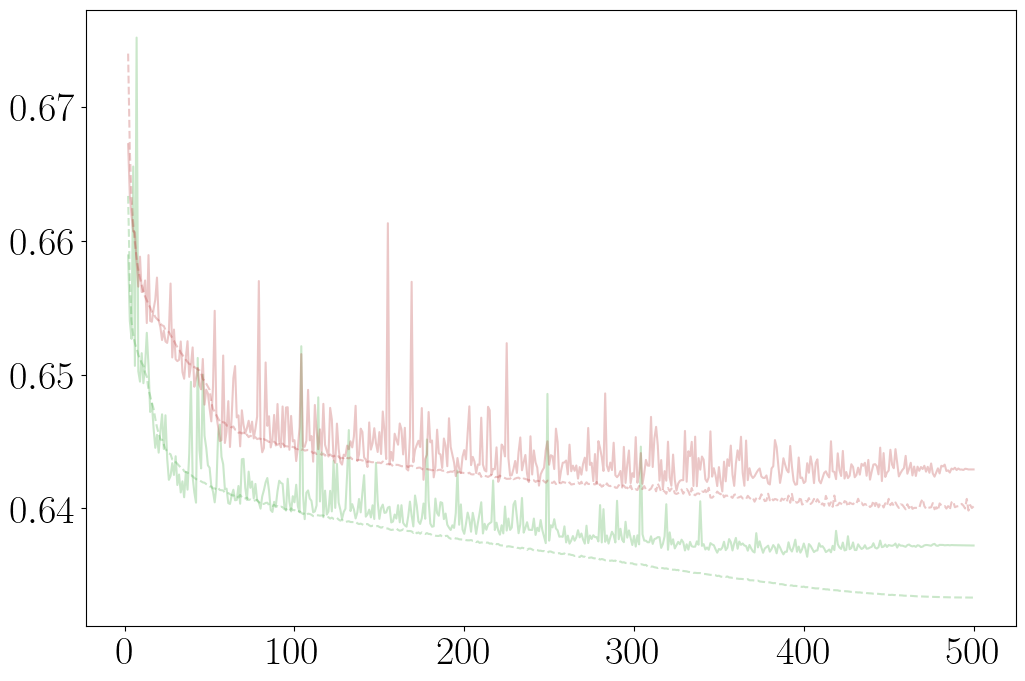

In [24]:
final_route = "plots/Omnifold/PtoP/"
'''
Losses
'''
route_omnifold = "output/Omnifold/20240226_161313_onlypythia-long/model"
route_bOmnifold = "output/Omnifold/20240226_161539_onlypythia-long-bay/model"

# Load the dictionaries from the .pth files
losses_omnifold = torch.load(route_omnifold + "/final.pth", map_location=torch.device('cpu'))['losses']
losses_bOmnifold = torch.load(route_bOmnifold + "/final.pth", map_location=torch.device('cpu'))['losses']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = np.arange(1, len(losses_bOmnifold["tr_loss"][:]))
ax.plot(epochs + 1, losses_omnifold["tr_loss"][1:], linestyle= 'dashed', color = AFF_INN_COLOR, alpha = 0.25)#label = 'Omn. train')
ax.plot(epochs + 1, losses_omnifold["val_loss"][1:], linestyle= 'solid', color = AFF_INN_COLOR, alpha = 0.25)#label = 'Omn. val')
ax.plot(epochs + 1, losses_bOmnifold["tr_loss"][1:], linestyle= 'dashed', color = "firebrick", alpha = 0.25)#label = 'bOmn. train')
ax.plot(epochs + 1, losses_bOmnifold["val_loss"][1:], linestyle= 'solid', color = "firebrick", alpha = 0.25)#label = 'bOmn. val')
#ax.plot(epochs + 1, losses_bOmnifold["val_MAP_loss"][6:], linestyle= 'solid', color = "blue", alpha = .75, label = 'bOmn. val. MAP')
#ax.plot(epochs + 1, losses_bOmnifold["val_MAP_bce"][6:], linestyle= 'dashed', color = "blue", alpha = .75, label = 'bOmn. val. MAP BCE-term')
ax.plot(epochs + 1, losses_omnifold["tr_bce"][1:], linestyle= 'dotted', color = "blue", alpha = .75, label = 'bOmn. train BCE-term')
ax.plot(epochs + 1, losses_omnifold["val_bce"][1:], linestyle= 'dashdot', color = "blue", alpha = .75, label = 'bOmn. val. BCE-term')
ax.plot(epochs + 1, losses_bOmnifold["tr_bce"][1:], linestyle= 'dotted', color = "darkorchid", alpha = .75, label = 'bOmn. train BCE-term')
ax.plot(epochs + 1, losses_bOmnifold["val_bce"][1:], linestyle= 'dashdot', color = "darkorchid", alpha = .75, label = 'bOmn. val. BCE-term')

ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_xlim(-20, 520)
ax.set_ylabel('Loss')
ax.set_ylim(0.63, 0.68)
ax.legend(loc= 'upper right', frameon= False)
#ax.grid(True, 'major', 'y', linestyle='--', color='grey', linewidth=1.0)
fig.tight_layout()
fig.savefig(final_route + "PtoP-losses_all-BCE_included.pdf", format= "pdf")

In [187]:
route_omnifold = "output/Omnifold/20240226_161313_onlypythia-long"
route_bOmnifold = "output/Omnifold/20240226_161539_onlypythia-long-bay"

routes = [route_omnifold, route_bOmnifold]

reco_train_all = []
for route in routes:
    with open(route + "/reco_train.pkl", "rb") as f:
        reco_train_all.append(pickle.load(f))

reco_all = []
for route in routes:
    with open(route + "/reco.pkl", "rb") as f:
        reco_all.append(pickle.load(f))

observables_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        observables_all.append(pickle.load(f))

In [188]:
'''
TRAINING SET RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "PtoP-reco_train.pdf") as pp:
    for reco_train_omnifold, reco_train_bOmnifold in zip(reco_train_all[0], reco_train_all[1]):
        
        obs = reco_train_bOmnifold["obs"]
        bins = reco_train_bOmnifold["bins"]

        # Pythia Reco 1
        line_Pythia_reco1 = reco_train_bOmnifold["lines"][0]
        line_Pythia_reco1.color = RECO_COLOR
        line_Pythia_reco1.y_ref = None

        # Pythia Reco 2
        line_Pythia_reco2 = reco_train_bOmnifold["lines"][1]
        line_Pythia_reco2.color = HARD_COLOR


        # omnifold reweighted
        line_omnifold = reco_train_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR

        # bOmnifold reweighted
        line_bOmnifold = reco_train_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco1, line_Pythia_reco2, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )



'''
RECO-LEVEL DISTRIBUTIONS
'''
with PdfPages(final_route + "PtoP-reco.pdf") as pp:
    for reco_omnifold, reco_bOmnifold in zip(reco_all[0], reco_all[1]):
        
        obs = reco_bOmnifold["obs"]
        bins = reco_bOmnifold["bins"]

        # Pythia Reco 1
        line_Pythia_reco1 = reco_bOmnifold["lines"][0]
        line_Pythia_reco1.color = RECO_COLOR
        line_Pythia_reco1.y_ref = None

        # Pythia Reco 2
        line_Pythia_reco2 = reco_bOmnifold["lines"][1]
        line_Pythia_reco2.color = HARD_COLOR


        # omnifold reweighted
        line_omnifold = reco_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR

        # bOmnifold reweighted
        line_bOmnifold = reco_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco1, line_Pythia_reco2, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )



'''
OBSERVABLES
'''
with PdfPages(final_route + "PtoP-observables.pdf") as pp:
    for observables_omnifold, observables_bOmnifold in zip(observables_all[0], observables_all[1]):
        
        obs = observables_bOmnifold["obs"]
        bins = observables_bOmnifold["bins"]

        # Pythia Reco 2
        line_Pythia_reco2 = observables_bOmnifold["lines"][0]
        line_Pythia_reco2.color = RECO_COLOR

        # Pythia Hard 2
        line_Pythia_hard2 = observables_bOmnifold["lines"][1]
        line_Pythia_hard2.color = HARD_COLOR
        
        # omnifold reweighted
        line_omnifold = observables_omnifold["lines"][2]
        line_omnifold.color = AFF_INN_COLOR
        
        # bOmnifold reweighted
        line_bOmnifold = observables_bOmnifold["lines"][2]
        line_bOmnifold.color = "firebrick"
        
        ylim = [1e0, 1e1] if "momentum" in obs.tex_label else None

        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco2, line_Pythia_hard2, line_omnifold, line_bOmnifold],
            bins=bins,
            observable=obs,
            show_ratios=True,
            xlim = [0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[.9, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )

## Plot dataset

In [138]:
route = "output/DiDi/paired/20240221_104350_small-long-bay"
with open(route + "/observables.pkl", "rb") as f:
    Pythia = pickle.load(f)
final_route = "plots/new_dataset/"

In [139]:
Pythia_hard = []
Pythia_reco = []
for k in range(len(Pythia)):
    Pythia_reco.append(Pythia[k]["lines"][0])
    Pythia_hard.append(Pythia[k]["lines"][1])

In [140]:
with PdfPages(final_route + "new_dataset.pdf") as pp:
    for observables_Pythia in Pythia:
        
        obs = observables_Pythia["obs"]
        bins = observables_Pythia["bins"]

        # Pythia Reco
        line_Pythia_reco = observables_Pythia["lines"][0]
        line_Pythia_reco.color = RECO_COLOR
        line_Pythia_reco.label = "Reco"
        line_Pythia_reco.linestyle = "solid"
        
        # Pythia Hard
        line_Pythia_hard = observables_Pythia["lines"][1]
        line_Pythia_hard.color = HARD_COLOR
        line_Pythia_hard.label = "Hard"
        line_Pythia_hard.linestyle = "solid"

        hist_plot(
            pdf=pp,
            lines=[line_Pythia_reco, line_Pythia_hard],
            bins=bins,
            observable=obs,
            show_ratios=False,
            xlim = [-0.05, 0.55] if "momentum" in obs.tex_label else None,
            ylim=[5e-1, 1e1] if "momentum" in obs.tex_label else [-0.01, 0.23] if "Groomed mass" in obs.tex_label else [-0.1, 3.2] if "subjettiness" in obs.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs.tex_label or "multiplicity" in obs.tex_label else "lower left" if "width" in obs.tex_label else "upper left" if "Groomed mass" in obs.tex_label or "subjettiness" in obs.tex_label else "upper right" if "momentum" in obs.tex_label else "best"), 'handlelength' : handlelength},
        )

## Effects of preprocessing

In [161]:
route_INN_nopreproc = "output/INN/RQS/20240226_085520_nopreproc-bay"
route_P_DIDI_nopreproc = "output/DiDi/paired/20240227_154514_nopreproc-small-short-bay-big_batch"
route_INN_both_preproc = "output/INN/RQS/20240220_181451_small-short-bay"
route_P_DIDI_both_preproc = "output/DiDi/paired/20240227_130018_small-short-bay-big_batch"

routes = [route_INN_nopreproc, route_P_DIDI_nopreproc, route_INN_both_preproc, route_P_DIDI_both_preproc]
comparison_all = []
for route in routes:
    with open(route + "/observables.pkl", "rb") as f:
        comparison_all.append(pickle.load(f))

n_unfoldings = int(comparison_all[0][3]["lines"][3].label.split(" ")[0])
print(f"{n_unfoldings} UNFOLDINGS")
final_route = "plots/new_dataset/"

50 UNFOLDINGS


In [162]:
INN_nopreproc = comparison_all[0]
P_DIDI_nopreproc = comparison_all[1]

with PdfPages(final_route + "preprocessing/no_preproc.pdf") as pp:
    for observable_INN, observable_P_DIDI in zip(INN_nopreproc, P_DIDI_nopreproc):

        # Reco
        line_reco = observable_INN["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_INN["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "cINN/CFM"
        
        # P_DIDI
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "DiDi/SB"

        
        # SB
        #line_SB = observable_P_DIDI["lines"][4]
        #line_SB.color = "black"
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_INN, line_P_DIDI],#, line_SB],
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            show_ratios=True,
            xlim = None,
            ylim=[5e-3, 1e1] if "momentum" in obs_P_DIDI.tex_label else [-0.005, 0.255] if "Groomed mass" in obs_P_DIDI.tex_label else [-0.1, 3.2] if "subjettiness" in obs_P_DIDI.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label or "subjettiness" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "best"), 'handlelength' : handlelength},
        )

In [163]:
INN_both_preproc = comparison_all[2]
P_DIDI_both_preproc = comparison_all[3]

with PdfPages(final_route + "preprocessing/both_preproc.pdf") as pp:
    for observable_INN, observable_P_DIDI in zip(INN_both_preproc, P_DIDI_both_preproc):

        # Reco
        line_reco = observable_INN["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"
        
        # Hard
        line_hard = observable_INN["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Hard"

        # INN
        obs_INN = observable_INN["obs"]
        bins_INN = observable_INN["bins"]
        line_INN = observable_INN["lines"][3]
        line_INN.color = INN_COLOR
        line_INN.label = "cINN/CFM"
        
        # P_DIDI
        obs_P_DIDI = observable_P_DIDI["obs"]
        bins_P_DIDI = observable_P_DIDI["bins"]
        line_P_DIDI = observable_P_DIDI["lines"][3]
        line_P_DIDI.color = P_DIDI_COLOR
        line_P_DIDI.label = "DiDi/SB"
        
        # SB
        #line_SB = observable_P_DIDI["lines"][4]
        #line_SB.color = "black"
        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_INN, line_P_DIDI],#, line_SB],
            bins=bins_P_DIDI,
            observable=obs_P_DIDI,
            show_ratios=True,
            xlim = None,
            ylim=[5e-3, 1e1] if "momentum" in obs_P_DIDI.tex_label else [-0.005, 0.255] if "Groomed mass" in obs_P_DIDI.tex_label else [-0.1, 3.2] if "subjettiness" in obs_P_DIDI.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_P_DIDI.tex_label or "multiplicity" in obs_P_DIDI.tex_label else "lower left" if "width" in obs_P_DIDI.tex_label else "upper left" if "Groomed mass" in obs_P_DIDI.tex_label or "subjettiness" in obs_P_DIDI.tex_label else "lower center" if "momentum" in obs_P_DIDI.tex_label else "best"), 'handlelength' : handlelength},
        )

## Calibration + single event unfolding

In [4]:
mpl.rcParams['font.size'] = 20 # 17 for SB on second panel
                               # larger for migration like 22
mpl.rcParams['lines.linewidth'] = 1.5

In [88]:
route_CFM = "output/CFM/smalllongbay-plot_single/"
route_P_DIDI = "output/DiDi/paired/smalllongbay-plot_single/"
route_U_DIDI = "output/DiDi/unpaired/smalllongbay-plot_single/"
route_INN = "output/INN/RQS/smalllongbay-plot_single/"

routes = [route_CFM, route_P_DIDI, route_U_DIDI, route_INN]
calibration_all = []
for route in routes:
    with open(route + "/calibration.pkl", "rb") as f:
        calibration_all.append(pickle.load(f))

final_route = "plots/new_dataset/calibration/"

In [89]:
calibration_CFM = calibration_all[0]
calibration_INN = calibration_all[3]

with PdfPages(final_route + "calibration-CFM_INN.pdf") as pp:
    for obs_CFM, obs_INN in zip(calibration_CFM, calibration_INN):
        fig, axs = plt.subplots(figsize=(8.5, 7))
        
        obs = obs_CFM["obs"]
        data_true_CFM = obs_CFM["data_true"]
        data_gen_CFM = obs_CFM["data_gen"]

        data_true_INN = obs_INN["data_true"]
        data_gen_INN = obs_INN["data_gen"]
        

        calibration_x = np.linspace(0, 1, 101)
        k=0
        for data_true, data_gen in zip([data_true_CFM, data_true_INN], [data_gen_CFM, data_gen_INN]):
            for i, (data_true_elem, data_gen_elem) in enumerate(
                zip(data_true, data_gen)
            ):
                quantiles = np.mean(data_gen_elem < data_true_elem[:, None], axis=1)

                calibration_y = np.mean(
                    quantiles[:, None] < calibration_x[None, :], axis=0
                )
                axs.plot(
                    calibration_x,
                    calibration_y,
                    color=CFM_COLOR if k == 0 else INN_COLOR,
                    alpha=.5,
                    label = "CFM" if k == 0 else "cINN"
                )
            k+=1
        axs.plot([0, 1], [0, 1], color="k", linestyle=":")
        axs.set_xlabel(f"q ${{{obs.tex_label}}}$")
        axs.set_ylabel("fraction of events")
        axs.legend(loc="best", frameon=False)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=observables_rect)
        fig.savefig(pp, format="pdf")
        plt.close()






calibration_DiDiP = calibration_all[1]
calibration_DiDiU = calibration_all[2]

with PdfPages(final_route + "calibration-DiDi.pdf") as pp:
    for obs_DiDiP, obs_DiDiU in zip(calibration_DiDiP, calibration_DiDiU):
        fig, axs = plt.subplots(figsize=(8.5, 7))
        
        obs = obs_DiDiP["obs"]
        data_true_DiDiP = obs_DiDiP["data_true"]
        data_gen_DiDiP = obs_DiDiP["data_gen"]

        data_true_DiDiU = obs_DiDiU["data_true"]
        data_gen_DiDiU = obs_DiDiU["data_gen"]
        

        calibration_x = np.linspace(0, 1, 101)
        k=0
        for data_true, data_gen in zip([data_true_DiDiP, data_true_DiDiU], [data_gen_DiDiP, data_gen_DiDiU]):
            for i, (data_true_elem, data_gen_elem) in enumerate(
                zip(data_true, data_gen)
            ):
                quantiles = np.mean(data_gen_elem < data_true_elem[:, None], axis=1)

                calibration_y = np.mean(
                    quantiles[:, None] < calibration_x[None, :], axis=0
                )
                axs.plot(
                    calibration_x,
                    calibration_y,
                    color=P_DIDI_COLOR if k == 0 else UP_DIDI_COLOR,
                    alpha=.5,
                    label = "DiDi-P" if k == 0 else "DiDi-U"
                )
            k+=1
        axs.plot([0, 1], [0, 1], color="k", linestyle=":")
        axs.set_xlabel(f"q ${{{obs.tex_label}}}$")
        axs.set_ylabel("fraction of events")
        axs.legend(loc="best", frameon=False)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=observables_rect)
        fig.savefig(pp, format="pdf")
        plt.close()

In [95]:
route_CFM = "output/CFM/smalllongbay-plot_single/"
route_P_DIDI = "output/DiDi/paired/smalllongbay-plot_single/"
route_U_DIDI = "output/DiDi/unpaired/smalllongbay-plot_single/"
route_INN = "output/INN/RQS/smalllongbay-plot_single/"

routes = [route_CFM, route_P_DIDI, route_U_DIDI, route_INN]
single_events_all = []
for route in routes:
    with open(route + "/single_events.pkl", "rb") as f:
        single_events_all.append(pickle.load(f))

final_route = "plots/new_dataset/single_events/"
mpl.rcParams['lines.linewidth'] = 2

In [98]:
with PdfPages(final_route + "single_events-all.pdf") as pp:
    for observable_CFM, observable_DiDiP, observable_DiDiU, observable_INN in zip(single_events_all[0], single_events_all[1], single_events_all[2], single_events_all[3]):
        
        obs_CFM = observable_CFM["obs"]
        bins_CFM = observable_CFM["bins"]
        
        # Truth
        line_truth = observable_CFM["lines"][0]
        line_truth.color = HARD_COLOR

        # Cond
        line_cond = observable_CFM["lines"][1]
        line_cond.color = RECO_COLOR
        line_cond.label = "Cond./Reco"

        # CFM
        line_gen_CFM = observable_CFM["lines"][2]
        line_gen_CFM.color = CFM_COLOR
        line_gen_CFM.label = "CFM"

        # INN
        line_gen_INN = observable_INN["lines"][2]
        line_gen_INN.color = INN_COLOR
        line_gen_INN.label = "cINN"

        # DiDiP
        line_gen_DiDiP = observable_DiDiP["lines"][3]
        line_gen_DiDiP.color = P_DIDI_COLOR
        line_gen_DiDiP.label = "DiDi-P"

        # DiDiU
        line_gen_DiDiU = observable_DiDiU["lines"][3]
        line_gen_DiDiU.color = UP_DIDI_COLOR
        line_gen_DiDiU.label = "DiDi-U"

        hist_plot(
            pdf=pp,
            lines=[line_truth, line_cond, line_gen_CFM, line_gen_INN, line_gen_DiDiP, line_gen_DiDiU],
            bins=bins_CFM,
            observable=obs_CFM,
            show_ratios=False,
            xlim = [0.05, 0.55] if "momentum" in obs_CFM.tex_label else [-14, -2] if "Groomed mass" in obs_CFM.tex_label else None,
            #ylim=[.9, 1e1] if "momentum" in obs_CFM.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_CFM.tex_label else [-0.1, 3.2] if "subjettiness" in obs_CFM.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_CFM.tex_label or "multiplicity" in obs_CFM.tex_label else "lower left" if "width" in obs_CFM.tex_label else "upper left" if "Groomed mass" in obs_CFM.tex_label or "subjettiness" in obs_CFM.tex_label else "upper right" if "momentum" in obs_CFM.tex_label else "best"), 'handlelength' : handlelength},
            legend_kwargs={"loc" : "best"}
        )

In [ ]:
with PdfPages(final_route + "single_events-DiDi.pdf") as pp:
    for observable_DiDiP, observable_DiDiU in zip(single_events_all[1], single_events_all[2]):
        
        obs_DiDiP = observable_DiDiP["obs"]
        bins_DiDiP = observable_DiDiP["bins"]
        
        # Truth
        line_truth = observable_DiDiP["lines"][0]
        line_truth.color = HARD_COLOR

        # Cond
        line_reco = observable_DiDiP["lines"][1]
        line_reco.color = RECO_COLOR
        line_reco.label = "Reco"

        # DiDiP
        line_gen_DiDiP = observable_DiDiP["lines"][3]
        line_gen_DiDiP.color = P_DIDI_COLOR
        line_gen_DiDiP.label = "DiDi-P"

        # DiDiU
        line_gen_DiDiU = observable_DiDiU["lines"][3]
        line_gen_DiDiU.color = UP_DIDI_COLOR
        line_gen_DiDiU.label = "DiDi-U"
        

        hist_plot(
            pdf=pp,
            lines=[line_truth, line_reco, line_gen_DiDiP, line_gen_DiDiU],
            bins=bins_DiDiP,
            observable=obs_DiDiP,
            show_ratios=False,
            xlim = [0.05, 0.55] if "momentum" in obs_DiDiP.tex_label else None,
            #ylim=[.9, 1e1] if "momentum" in obs_DiDiP.tex_label else [-0.01, 0.23] if "Groomed mass" in obs_DiDiP.tex_label else [-0.1, 3.2] if "subjettiness" in obs_DiDiP.tex_label else None,
            #plot_SB_on_second_panel=True,
            show=True,
            rect=observables_rect, # left, bottom, right, top
            #legend_kwargs={"loc": ("upper right" if "Jet mass" in obs_DiDiP.tex_label or "multiplicity" in obs_DiDiP.tex_label else "lower left" if "width" in obs_DiDiP.tex_label else "upper left" if "Groomed mass" in obs_DiDiP.tex_label or "subjettiness" in obs_DiDiP.tex_label else "upper right" if "momentum" in obs_DiDiP.tex_label else "best"), 'handlelength' : handlelength},
            legend_kwargs={"loc" : "best"}
        )